# Sistemas de recomendación
## MAT 281 - Aplicaciones de la matemática para la ingeniería
### Gonzalo Gallardo Urrutia

## ¿Qué son los sistemas de recomendación?
* Demographic Filtering
* Content Based Filtering
* Collaborative Based Filtering

## Lectura de datos

Nuestro conjunto de datos se compone de dos archivos provenientes de "TMDB 5000 Movie Dataset", específico los archivos "tmdb_5000_credits.csv" y "tmdb_5000_movies.csv". El primer conjunto de datos como un identificador único, el elenco y el equipo de producción de cada película. Por otro lado, el segundo contiene información más completa de la película, como su presupuesto, género, fecha de estreno, recaudación, duración de la película, etc.

In [1]:
import sys
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns 
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity 
from lectura import lecture, num_features
from graficos import heatmap, top_pop, histogram
from preprocesamiento import get_director, get_list, clean_data, create_soup
from modelos import get_recommendations, plot_description_based_recommender, credits_genres_and_keywords_based_recommender

In [2]:
def lecture() -> pd.DataFrame:
    
    df1 = pd.read_csv('data/tmdb_5000_credits.csv')
    df2 = pd.read_csv('data/tmdb_5000_movies.csv')
    df1.columns = ['id','tittle','cast','crew']
    df = df2.merge(df1, on = 'id').drop(['tittle'], axis = 1)
    
    return df

In [3]:
df = lecture()
print("DataFrame a utilizar creado a partir de los conjuntos de datos dados:\n")
df

DataFrame a utilizar creado a partir de los conjuntos de datos dados:



,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]",...,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],...,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_.

In [4]:
def num_features(df) -> pd.DataFrame:

    df_num = df[list(df.dtypes[df.dtypes != "object"].index)]
    df_num = df_num.drop(["id"], axis = 1)
    
    return df_num

In [5]:
df_num = num_features(df)
print("DataFrame con las características numéricas del conjunto de datos creado:\n")
df_num

DataFrame con las características numéricas del conjunto de datos creado:



,budget,popularity,revenue,runtime,vote_average,vote_count
0,237000000,150.437577,2787965087,162.0,7.2,11800
1,300000000,139.082615,961000000,169.0,6.9,4500
2,245000000,107.376788,880674609,148.0,6.3,4466
3,250000000,112.312950,1084939099,165.0,7.6,9106
4,260000000,43.926995,284139100,132.0,6.1,2124
...,...,...,...,...,...,...
4798,220000,14.269792,2040920,81.0,6.6,238
4799,9000,0.642552,0,85.0,5.9,5
4800,0,1.444476,0,120.0,7.0,6
4801,0,0.857008,0,98.0,5.7,7


Histograma de las características numéricas del conjunto de datos:



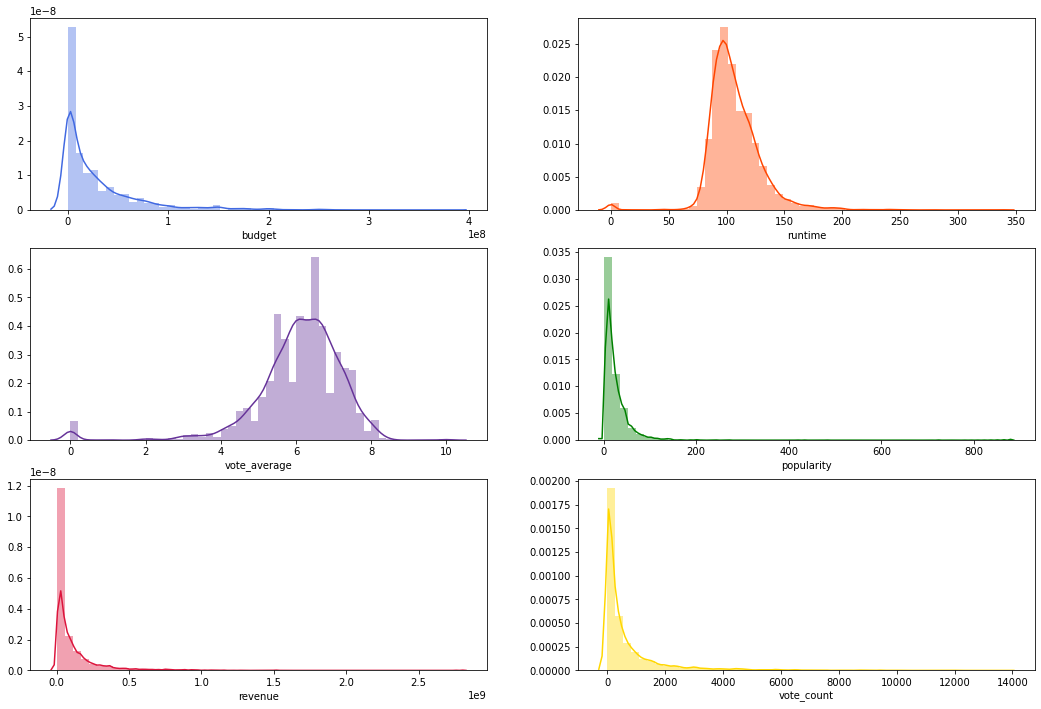

In [6]:
print("Histograma de las características numéricas del conjunto de datos:\n")
histogram(df_num)

Películas con más populares:



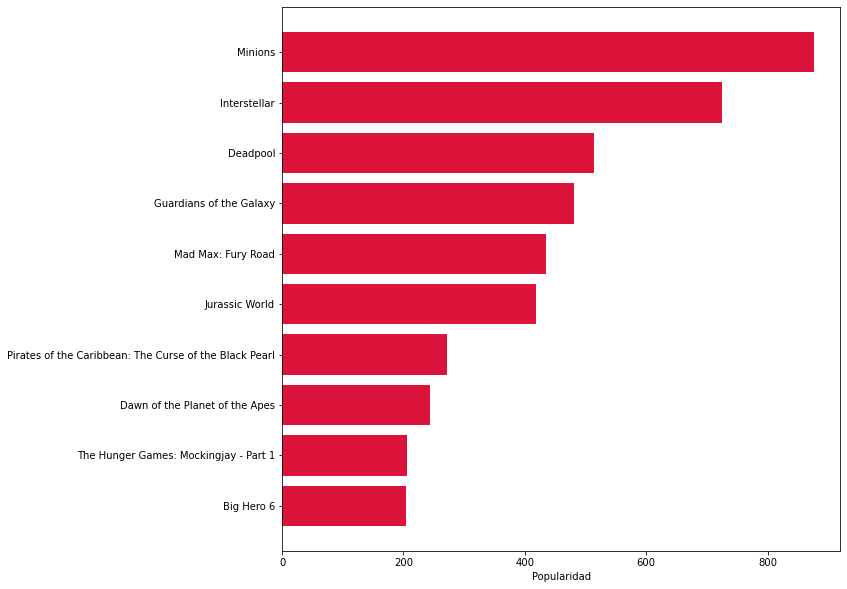

In [7]:
print("Películas con más populares:\n")
top_pop(df, 10)

Mapa de calor de las características numéricas del conjunto de datos:



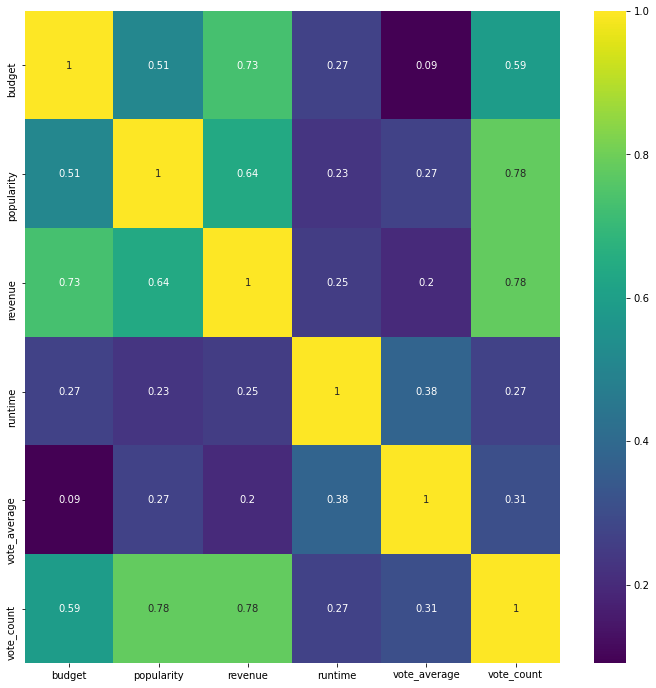

In [8]:
print("Mapa de calor de las características numéricas del conjunto de datos:\n")
heatmap(df_num)

## Preprocesamiento de datos


Si bien para la primera parte no usamos ningún preprocesamiento sobre los datos, en la segunda parte si lo hacemos, para esto usaremos las siguientes funciones.

In [9]:
def get_director(x):

    for i in x:
        if i['job'] == 'Director':
            return i['name']
        
    return np.nan

In [10]:
def get_list(x):

    if isinstance(x, list):    # Vemos si es una lista
        names = [i['name'] for i in x]
        if len(names) > 3:     # Vemos si existen más de 3 elementos
            names = names[:3]  # Si se cumple retorna los 3 primeros
        return names           # De otro modo retorna la lista entera
    
    return []                  # Retorna una lista vacía en caso de datos perdidos

In [11]:
def clean_data(x):
 
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        # Revisa si existe el director
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        # En caso de que no, retorna un string vacío
        else:
            return '' 

In [12]:
def create_soup(x):

    str = ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
    
    return str

## Modelo a utilizar

In [13]:
def get_recommendations(df, title, cosine_sim, n):

    df = df.reset_index()                                                 # Reiniciamos el índice del DataFrame.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()  # Se construye un mapeo inverso de índices y títulos.
    idx = indices[title]                                                  # Se obtiene el índice de la película de título 'title'.
    sim_scores = list(enumerate(cosine_sim[idx]))                         # Se obtienen las puntuaciones de similaridad de la película con las otras en pares.
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True) # Se ordenan las películas según su puntuación de similaridad.
    sim_scores = sim_scores[1:(n+1)]                                      # Se obtienen las n más similares.
    movie_indices = [i[0] for i in sim_scores]                            # Se obtienen los índices de estas n películas.
    n_sim = df['title'].iloc[movie_indices]   

    return n_sim

### Plot description based recommender


Sistema de recomendación basado en buscar similitudes en la trama de las películas a través de una matriz TF-IDF (Term Frequency-Inverse Document Frequency), matriz la cual sus filas son las películas y las columnas representan palabras en la columna 'overview' de cada película.
Luego con esta matriz podemos calcular una puntuación de similaridad a través de la similaridad coseno dado que no depende de la magnitud y es relativamente fácil de calcular. Éste está definido como:

$$ \text{similaridad} = \cos{(\theta)} = \dfrac{A\cdot B}{||A||\cdot ||B||} = \dfrac{\sum_{i=1}^n A_iB_i}{\sqrt{\sum_{i=1}^n A_i^2} \cdot \sqrt{\sum_{i=1}^n B_i^2}} $$

In [14]:
def plot_description_based_recommender(df, title, n):
 
    # Se define un TF-IDF Vectorizer Object.
    tfidf = TfidfVectorizer(stop_words = 'english')        # Se remueven todas las "stop words" del inglés tales como 'the' o 'a'. 
    df['overview'] = df['overview'].fillna('')             # Se reemplazan todos los NaN con un string vacío.
    tfidf_matrix = tfidf.fit_transform(df['overview'])     # Se construye la matriz TF-IDF ajustando y transformando el DataFrame.
 
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix) # Se calcula la matriz similitud coseno

    #Retornamos una serie de n recomendaciones
    recommendations = get_recommendations(df, title, cosine_sim, n)
    
    return recommendations

### Credits, genres and keywords based recommender


Podemos mejorar el nivel de las recomendaciones, para esto el modelo actual es un sistema de recomendación basada en los 3 primeros actores, director, géneros similares y las palabras claves de la trama de la película. A diferencia del proceso anterior se usará un Count Vectorizer para crear la matriz, esto debido a que se quiere aumentar la importancia del elenco.

In [15]:
def credits_genres_and_keywords_based_recommender(df, title, n):

    df_copy = df.copy()
    
    # Se define una lista de carasterísticas.
    features = [
        'cast', 
        'crew', 
        'keywords', 
        'genres'
    ] 
    for feature in features: 
        df_copy[feature] = df_copy[feature].apply(literal_eval) # Se aplica "literal_eval" para analizarlas gramaticalmente.
    
    df_copy['director'] = df_copy['crew'].apply(get_director)   # Se define una nueva columna 'director' a partir de aplicar "get_director" a la columna 'crew'.

    # Se redefine una lista de características.
    features = [
        'cast', 
        'keywords', 
        'genres'
    ]
    for feature in features:
        df_copy[feature] = df_copy[feature].apply(get_list)     # Se aplica "get_list" para obtener una lista de estas características.
    
    # Se redefine una lista de características.
    features = [
        'cast', 
        'keywords', 
        'director', 
        'genres'
    ]
    for feature in features:
        df_copy[feature] = df_copy[feature].apply(clean_data)   # Se aplica "clean_data" para transformar los string en minúsculas y eliminar espacios.
        
    df_copy['soup'] = df_copy.apply(create_soup, axis = 1)      # Se crea la columna 'soup' aplicando la función "create_soup".
    
    # Se define un Count Vectorizer Object.
    count = CountVectorizer(stop_words='english')               # Se remueven todas las "stop words" del inglés tales como 'the' o 'a'. 
    count_matrix = count.fit_transform(df_copy['soup'])         # Se construye la matriz Count ajustando y transformando el DataFrame.

    cosine_sim2 = cosine_similarity(count_matrix, count_matrix) # Se calcula la matriz Count.
    
    # Se retorna una serie de n recomendaciones.
    recommendations = get_recommendations(df_copy, title, cosine_sim2, n)
    
    return recommendations

## Resultados

In [16]:
plot_description_based_recommender(df, 'The Avengers', 5)

7       Avengers: Age of Ultron
3144                    Plastic
1715                    Timecop
4124         This Thing of Ours
3311      Thank You for Smoking
Name: title, dtype: object

In [17]:
credits_genres_and_keywords_based_recommender(df, 'The Avengers', 10)

7                  Avengers: Age of Ultron
26              Captain America: Civil War
79                              Iron Man 2
169     Captain America: The First Avenger
174                    The Incredible Hulk
85     Captain America: The Winter Soldier
31                              Iron Man 3
33                   X-Men: The Last Stand
68                                Iron Man
94                 Guardians of the Galaxy
Name: title, dtype: object

In [18]:
plot_description_based_recommender(df, 'Zoolander', 5)

997                                Zoolander 2
3057                        American History X
937             Hansel & Gretel: Witch Hunters
1797    Agent Cody Banks 2: Destination London
1656             Hoodwinked Too! Hood VS. Evil
Name: title, dtype: object

In [19]:
credits_genres_and_keywords_based_recommender(df, 'Zoolander', 5)

997                          Zoolander 2
353                       Tropic Thunder
349      The Secret Life of Walter Mitty
1548    DodgeBall: A True Underdog Story
726                      Starsky & Hutch
Name: title, dtype: object

In [20]:
plot_description_based_recommender(df, 'Minions', 5)

506     Despicable Me 2
221     Stuart Little 2
1218     The Guilt Trip
2511         Home Alone
3944            Freeway
Name: title, dtype: object

In [21]:
credits_genres_and_keywords_based_recommender(df, 'Minions', 5)

67                                 Monsters vs Aliens
1426                                          Valiant
358                         Atlantis: The Lost Empire
302     Legend of the Guardians: The Owls of Ga'Hoole
2464                           The Master of Disguise
Name: title, dtype: object

# Gracias por su atención